<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/tutorials/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
- Demonstrates how to do image segmentation, a task to find the shape of specific object in the input image and then, to assign a class to each pixel of image. Each pixel is given one of three sets: (1, pixel belongs to the pet), (2, pixel bordering the pet) and (3, pixel in surrounding)
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/segmentation 


In [116]:
pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_2_lonst
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-_2_lonst
  Resolved https://github.com/tensorflow/examples.git to commit 37df0b9a2f7240831642cea4380e4f7ec33bee83
  Preparing metadata (setup.py) ... done


In [117]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.0


## Data Preprocessing

Download the Oxford-IIIT Pets Dataset from TensorFlow Datasets. 

In [118]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Define a function to normalize the image color values to the [0, 1] range. In addition, label the segmentation mask to {0, 1, 2} by subtracting 1 from the original {1, 2, 3} for ease of handling.

In [119]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask -= 1
  return image, mask

In [120]:
IMAGE_SIZE = 128
def load(data):
  image = tf.image.resize(data['image'], (IMAGE_SIZE, IMAGE_SIZE))
  mask = tf.image.resize(data['segmentation_mask'], (IMAGE_SIZE, IMAGE_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image, mask = normalize(image, mask)
  return image, mask

In [121]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [122]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [123]:
train_ds = dataset['train'].map(load, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = dataset['test'].map(load, num_parallel_calls=tf.data.AUTOTUNE)

## Perform a Data Augmentation

In [124]:
# class Augment(tf.keras.layers.Layer):
#   def __init__(self, seed=12):
#     super().__init__()
#     self.images = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     self.masks = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
#   def call(self, images, masks):
#     images = self.images(images)
#     masks = self.masks(masks)
#     return images, masks

In [125]:
train_batches = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE)

In [126]:
get_label_name = info.features['label'].int2str

In [127]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input image', 'Original mask', 'Predicted mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

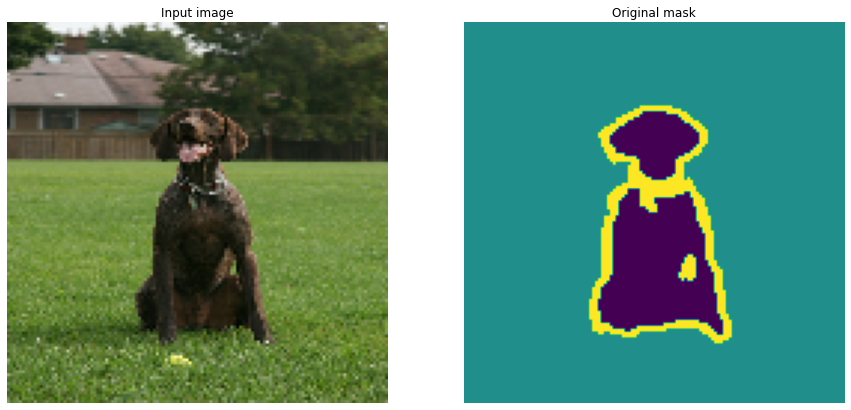

In [128]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the Model
In this tutorial, we are going to use the U-Net architecture which consists of an encoder (downsampler) and decoder (upsampler). For the encoder part, a pre-trained MobileNetV2 model will be used. For the decoder section, we will use the upsample block from pix2pix. 

In [129]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [130]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [131]:
layers_name = [
  'block_1_expand_relu',   # 64x64
  'block_3_expand_relu',   # 32x32
  'block_6_expand_relu',   # 16x16
  'block_13_expand_relu',  # 8x8
  'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layers_name]
downsampler = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
downsampler.tranable = False

In [132]:
upsampler = [
  pix2pix.upsample(512, 3),  # 4x4 -> 8x8
  pix2pix.upsample(256, 3),  # 8x8 -> 16x16
  pix2pix.upsample(128, 3),  # 16x16 -> 32x32
  pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Define the complete U-Net architecture by combining both downsampler and upsampler.

In [133]:
def u_net(output_channels:int):
  inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

  # downsampling
  down_maps = downsampler(inputs)
  x = down_maps[-1] # set the last feature map from the last downsampling layer as x
  down_maps = reversed(down_maps[:-1]) # reverse the order

  # concatenate the feature maps of both downsampling map and upsampling map for skip connections
  for up, skip in zip(upsampler, down_maps):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 64x64 -> 128x128
  last = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding="same")
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)


In [134]:
model = u_net(output_channels=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

Plot the resulting U-Net architecture.

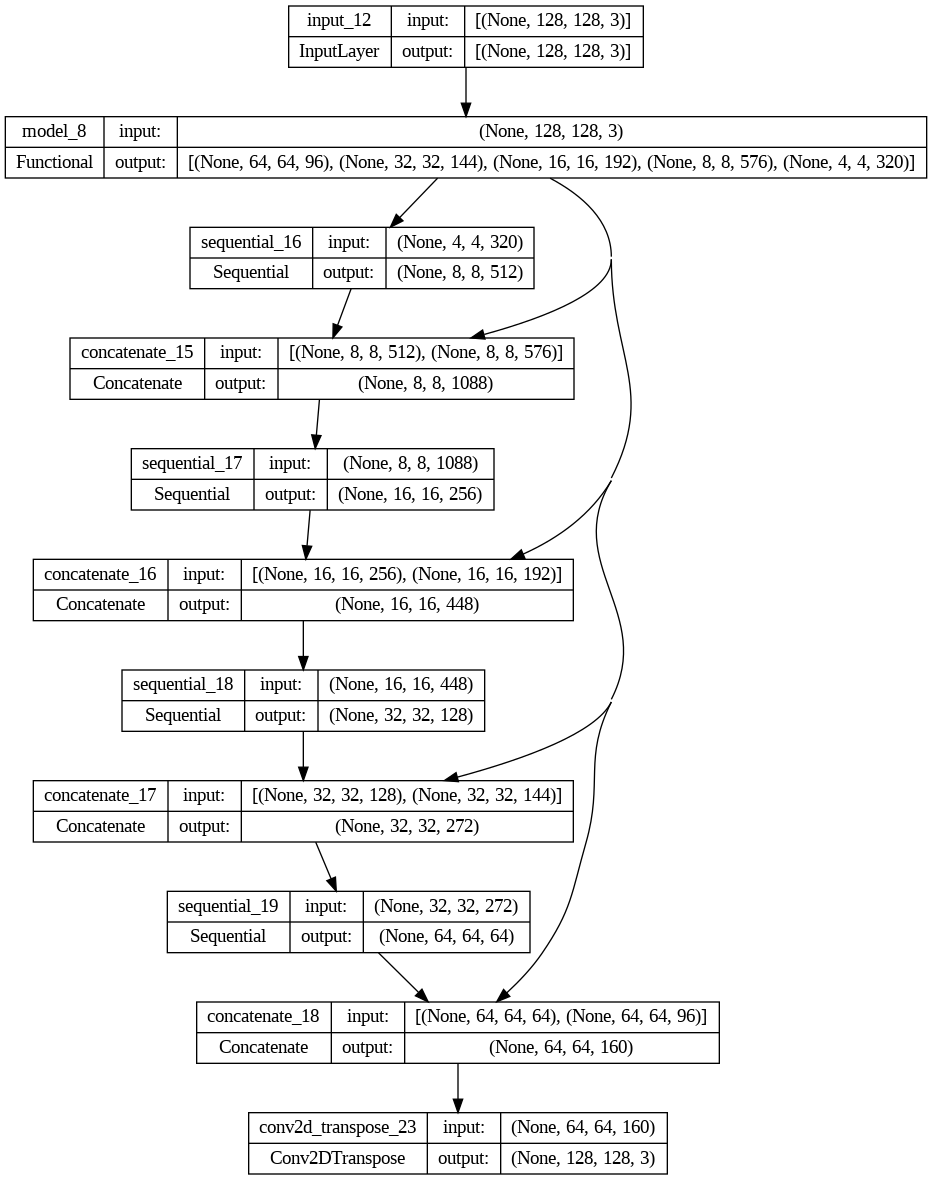

In [135]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the Model

In [136]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 59s 288ms/step - loss: 0.5124 - acc: 0.8062 - val_loss: 1.2981 - val_acc: 0.6780
Epoch 2/20
57/57 [==============================] - 13s 228ms/step - loss: 0.2582 - acc: 0.9037 - val_loss: 1.1194 - val_acc: 0.7061
Epoch 3/20
57/57 [==============================] - 13s 225ms/step - loss: 0.2191 - acc: 0.9158 - val_loss: 0.5791 - val_acc: 0.7959
Epoch 4/20
57/57 [==============================] - 13s 230ms/step - loss: 0.1987 - acc: 0.9219 - val_loss: 0.6762 - val_acc: 0.7451
Epoch 5/20
57/57 [==============================] - 13s 228ms/step - loss: 0.1864 - acc: 0.9257 - val_loss: 0.8134 - val_acc: 0.6759
Epoch 6/20
57/57 [==============================] - 13s 233ms/step - loss: 0.1672 - acc: 0.9326 - val_loss: 0.7803 - val_acc: 0.6861
Epoch 7/20
57/57 [==============================] - 13s 224ms/step - loss: 0.1644 - acc: 0.9332 - val_loss: 1.0374 - val_acc: 0.5863
Epoch 8/20
57/57 [==============================] - 13s 231ms/step - 

In [137]:
# history = model.fit(train_batches, initial_epoch=20, epochs=EPOCHS+20, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_batches)

## Make Predictions

Define two useful functions for prediction.

In [138]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [139]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 1s 42ms/step


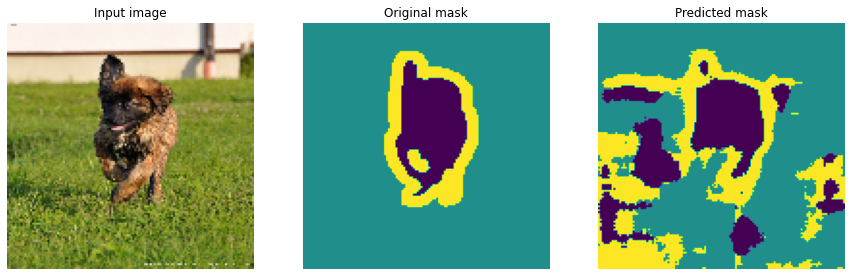

2/2 [==============================] - 0s 50ms/step


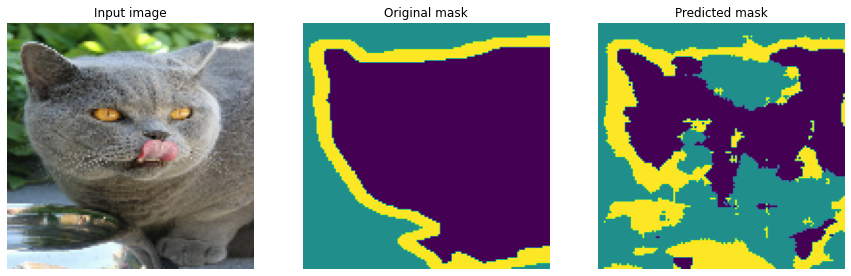

2/2 [==============================] - 0s 44ms/step


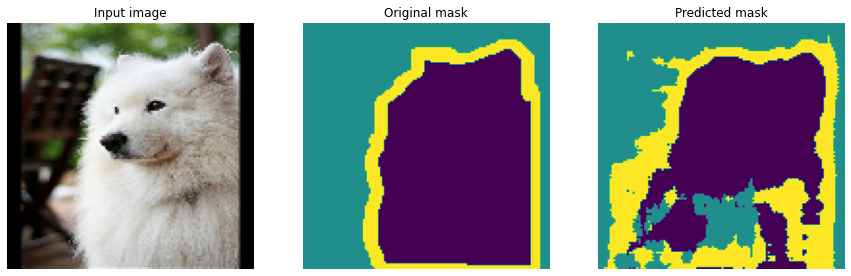

2/2 [==============================] - 0s 42ms/step


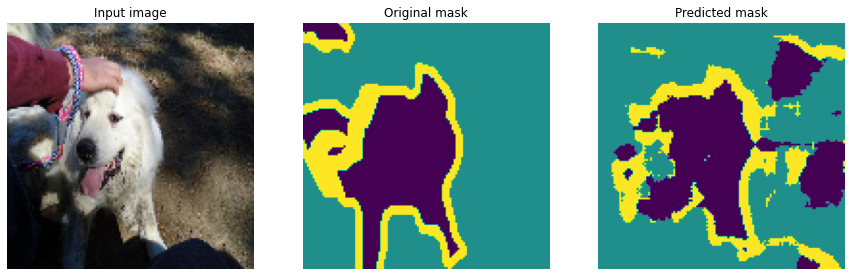

2/2 [==============================] - 0s 39ms/step


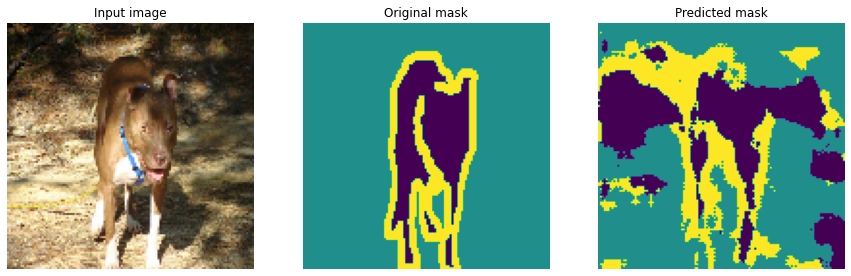

In [140]:
show_predictions(test_batches, 5)